In [1]:
# ДЗ 2
# # Зашумить изображение при помощи шума гаусса, постоянного шума. # Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# # Выяснить, какой фильтр показал лучший результат фильтрации шума.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, mean_squared_error

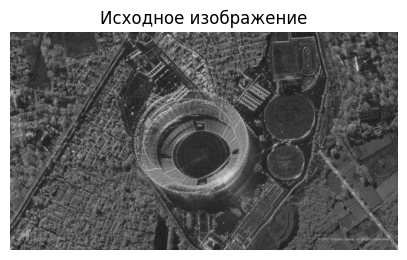

In [3]:
image = cv2.imread('sar_1.jpg', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='gray')
plt.title("Исходное изображение")
plt.axis('off')
plt.show()

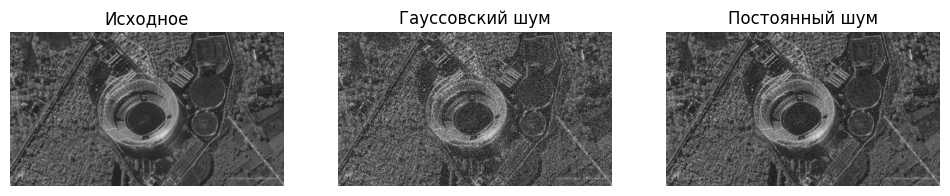

In [4]:
def add_gaussian_noise(img, mean=0, sigma=65):
    gauss = np.random.normal(mean, sigma, img.shape)
    noisy = img.astype(np.float32) + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# --- Постоянный (равномерный) шум ---
def add_uniform_noise(img, low=-60, high=60):
    uniform = np.random.uniform(low, high, img.shape)
    noisy = img.astype(np.float32) + uniform
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# Применяем шумы
gaussian_noisy = add_gaussian_noise(image)
uniform_noisy = add_uniform_noise(image)

# Визуализация
plt.figure(figsize=(12,4))
plt.subplot(1,3,1), plt.imshow(image, cmap='gray'), plt.title("Исходное"), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(gaussian_noisy, cmap='gray'), plt.title("Гауссовский шум"), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(uniform_noisy, cmap='gray'), plt.title("Постоянный шум"), plt.axis('off')
plt.show()

In [5]:

def evaluate_metrics(original, filtered):
    mse_val = mean_squared_error(original, filtered)
    ssim_val = ssim(original, filtered, data_range=255)
    return mse_val, ssim_val


In [6]:
def test_filters(noisy_img, name):
    results = {}
    print(f"\n=== Тестирование фильтров для шума: {name} ===")

    # --- Медианный фильтр ---
    for k in [3, 5, 7]:
        filtered = cv2.medianBlur(noisy_img, k)
        mse_val, ssim_val = evaluate_metrics(image, filtered)
        results[f"Median k={k}"] = (mse_val, ssim_val)

    # --- Гауссовский фильтр ---
    for k in [3, 5, 7]:
        filtered = cv2.GaussianBlur(noisy_img, (k, k), 0)
        mse_val, ssim_val = evaluate_metrics(image, filtered)
        results[f"Gaussian k={k}"] = (mse_val, ssim_val)

    # --- Билатеральный фильтр ---
    for d in [5, 9, 15]:
        filtered = cv2.bilateralFilter(noisy_img, d, 75, 75)
        mse_val, ssim_val = evaluate_metrics(image, filtered)
        results[f"Bilateral d={d}"] = (mse_val, ssim_val)

    # --- Фильтр нелокальных средних ---
    for h in [5, 10, 20]:
        filtered = cv2.fastNlMeansDenoising(noisy_img, None, h, 7, 21)
        mse_val, ssim_val = evaluate_metrics(image, filtered)
        results[f"NLM h={h}"] = (mse_val, ssim_val)

    # Вывод таблицы
    print(f"{'Фильтр':<25} | {'MSE':<12} | {'SSIM'}")
    print("-"*50)
    for k, (m, s) in results.items():
        print(f"{k:<25} | {m:<12.3f} | {s:.4f}")

    # Определение лучшего по SSIM
    best = max(results.items(), key=lambda x: x[1][1])
    print(f"\n➡ Лучший фильтр для {name}: {best[0]} (SSIM={best[1][1]:.4f})")

    # Визуализация лучшего
    best_filter_name = best[0].split()[0]
    param = int(best[0].split('=')[1])

    if best_filter_name == "Median":
        best_filtered = cv2.medianBlur(noisy_img, param)
    elif best_filter_name == "Gaussian":
        best_filtered = cv2.GaussianBlur(noisy_img, (param, param), 0)
    elif best_filter_name == "Bilateral":
        best_filtered = cv2.bilateralFilter(noisy_img, param, 75, 75)
    else:
        best_filtered = cv2.fastNlMeansDenoising(noisy_img, None, param, 7, 21)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1), plt.imshow(image, cmap='gray'), plt.title("Оригинал"), plt.axis('off')
    plt.subplot(1,3,2), plt.imshow(noisy_img, cmap='gray'), plt.title(name), plt.axis('off')
    plt.subplot(1,3,3), plt.imshow(best_filtered, cmap='gray'), plt.title(f"Лучший: {best[0]}"), plt.axis('off')
    plt.show()

    return results


=== Тестирование фильтров для шума: Гауссовский шум ===
Фильтр                    | MSE          | SSIM
--------------------------------------------------
Median k=3                | 796.349      | 0.3454
Median k=5                | 465.777      | 0.3947
Median k=7                | 403.922      | 0.3888
Gaussian k=3              | 562.489      | 0.4294
Gaussian k=5              | 395.511      | 0.4883
Gaussian k=7              | 336.431      | 0.5066
Bilateral d=5             | 982.353      | 0.3202
Bilateral d=9             | 789.123      | 0.3259
Bilateral d=15            | 782.384      | 0.3010
NLM h=5                   | 3278.273     | 0.1628
NLM h=10                  | 3278.273     | 0.1628
NLM h=20                  | 3277.823     | 0.1628

➡ Лучший фильтр для Гауссовский шум: Gaussian k=7 (SSIM=0.5066)


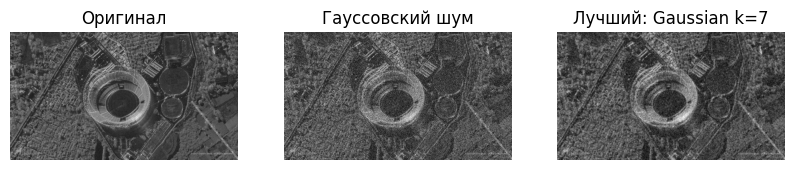


=== Тестирование фильтров для шума: Постоянный шум ===
Фильтр                    | MSE          | SSIM
--------------------------------------------------
Median k=3                | 409.223      | 0.4820
Median k=5                | 324.505      | 0.4755
Median k=7                | 332.089      | 0.4352
Gaussian k=3              | 228.990      | 0.6331
Gaussian k=5              | 198.955      | 0.6484
Gaussian k=7              | 212.137      | 0.6162
Bilateral d=5             | 238.680      | 0.6143
Bilateral d=9             | 236.142      | 0.5834
Bilateral d=15            | 285.547      | 0.5185
NLM h=5                   | 1167.201     | 0.3431
NLM h=10                  | 1167.201     | 0.3431
NLM h=20                  | 730.305      | 0.4221

➡ Лучший фильтр для Постоянный шум: Gaussian k=5 (SSIM=0.6484)


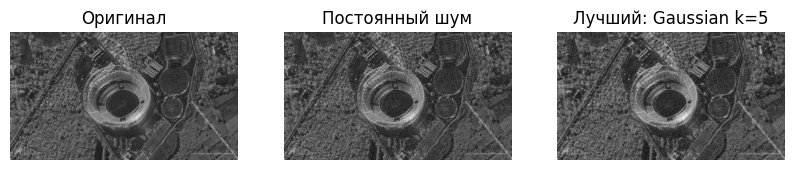

In [7]:
results_gauss = test_filters(gaussian_noisy, "Гауссовский шум")
results_uniform = test_filters(uniform_noisy, "Постоянный шум")

In [8]:
def find_best(results_dict):
    return max(results_dict.items(), key=lambda x: x[1][1])

best_g = find_best(results_gauss)
best_u = find_best(results_uniform)

print("\nИТОГОВЫЙ ВЫВОД")
print(f" Для ГАУССОВСКОГО шума лучший фильтр: {best_g[0]} (SSIM={best_g[1][1]:.4f}, MSE={best_g[1][0]:.2f})")
print(f" Для ПОСТОЯННОГО шума лучший фильтр: {best_u[0]} (SSIM={best_u[1][1]:.4f}, MSE={best_u[1][0]:.2f})")



ИТОГОВЫЙ ВЫВОД
 Для ГАУССОВСКОГО шума лучший фильтр: Gaussian k=7 (SSIM=0.5066, MSE=336.43)
 Для ПОСТОЯННОГО шума лучший фильтр: Gaussian k=5 (SSIM=0.6484, MSE=198.95)
